In [22]:
cd /Users/justinanguyen/Desktop/BrainStation/Projects/Capstone/Justina_Nguyen_Capstone_Submission

/Users/justinanguyen/Desktop/BrainStation/Projects/Capstone/Justina_Nguyen_Capstone_Submission


In [23]:
# Standard imports
import numpy as np
import pandas as pd
pd.set_option('display.max_rows', None)
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
%matplotlib inline
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.tokenize import sent_tokenize
#from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF
import string
from collections import Counter
from sklearn.linear_model import LogisticRegression
# For performing regex operations
import re

In [24]:
# Reading the csv file into a dataframe
drug_df = pd.read_csv('./clean_preprocessed_drug_reviews.csv', index_col=0)

In [25]:
# Create new dataframe
lr_df = drug_df.copy()

In [52]:
lr_df.head()

,date,review,rating,upvotes,page,sentiment,drugDuration,Alli (orlistat),Contrave (bupropion / naltrexone),Ozempic (semaglutide),Qsymia (phentermine / topiramate),Saxenda (liraglutide),Wegovy (semaglutide),Xenical (orlistat)
0,"February 27, 2023",I have been taking Wegovy for 1 week and 2 day...,10,622,1,1,1,0,0,0,0,0,1,0
1,"April 3, 2023",Starting week 9 with the second injection of 1...,7,216,1,0,0,0,0,0,0,0,1,0
2,"April 18, 2023",Tomorrow I will take my 3rd shot of .5mg (prev...,10,167,1,1,0,0,0,0,0,0,1,0
3,"March 14, 2023",I was hesitant to try Ozempic for weight loss ...,10,231,1,1,0,0,0,1,0,0,0,0
4,"February 6, 2022",6 months. -65 pounds. Hypertension gone. Pre D...,10,709,1,1,0,0,0,0,0,0,1,0


### Ratings

Let's look at the distribution of the `rating` column.

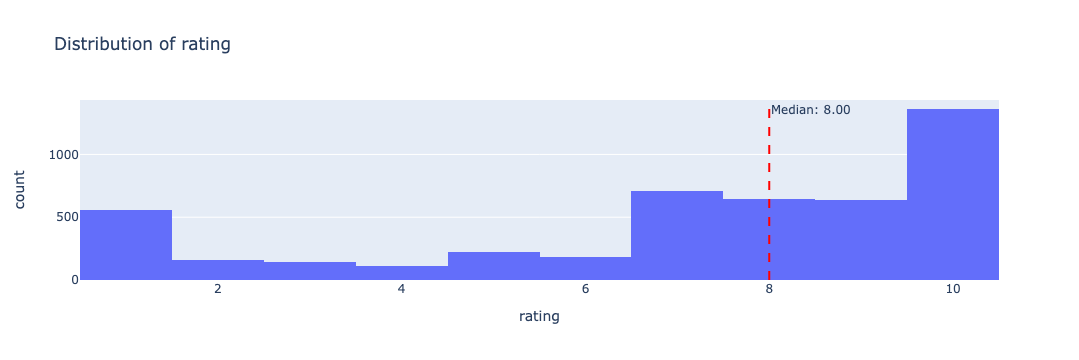

In [26]:
# Calculate the median of the "rating" column
median_rating = lr_df['rating'].median()

# Plot histogram with median line
fig = px.histogram(lr_df, x='rating', title='Distribution of rating')
fig.add_vline(x=median_rating, line_dash="dash", line_color="red", annotation_text=f'Median: {median_rating:.2f}')
fig.update_layout(showlegend=False)

# Show the figure
fig.show()

In the graph above, we can see that `rating` has a semi-bimodal but more of a left-skewed distribution. This makes sense because reviews tend to be rated really good or really bad. To address this distribution imbalance, we can create a new column named `sentiment` and binarize the original column where reviews below 9 will be encoded as 0 ("not good") and reviews with scores 9 and 10 as 1 ("good"). Once is has been binarized, we can drop the original column.

In [27]:
# Create sentiment feature from ratings
# If rating > 8 sentiment = 1 (positive)
# If rating <= 8 sentiment = 0 (negative)
lr_df['sentiment'] = np.where(lr_df['rating'] < 9, 0, 1)

Now, we can plot the distribution of `sentiment` to see what it looks like.

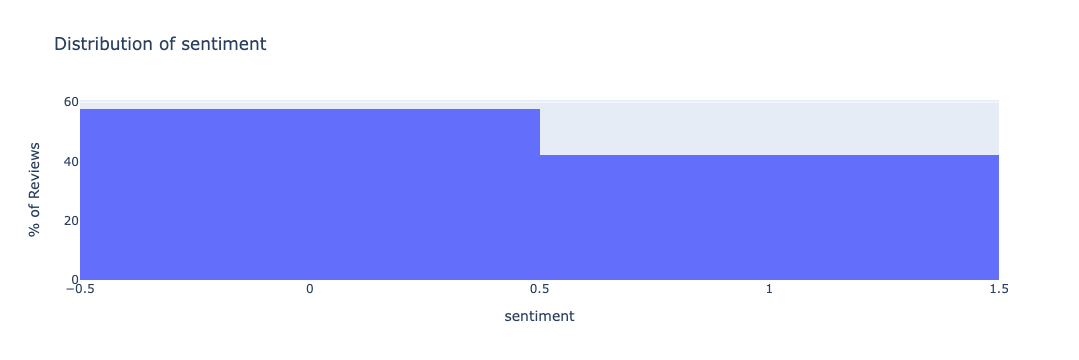

In [28]:
# Plot histogram with median line
fig = px.histogram(lr_df, x='sentiment', title='Distribution of sentiment')

# Update figure properties
fig.update_layout(yaxis_title='% of Reviews', showlegend=False)

# Normalize the sentiment
fig.update_traces(histnorm='percent')

# Show the figure
fig.show()

In [29]:
# Checking the percent
lr_df['sentiment'].value_counts()/lr_df.shape[0]

0    0.576801
1    0.423199
Name: sentiment, dtype: float64

In [30]:
# Checking the datatypes
lr_df.dtypes

uniqueID     object
duration     object
date         object
drugName     object
review       object
rating        int64
upvotes       int64
drug         object
page          int64
sentiment     int64
dtype: object

### Unique ID

Let's first look at the `uniqueID` column.

In [31]:
unique_val = lr_df['uniqueID'].nunique()
print('There are {} unique values.'.format(unique_val))

There are 3560 unique values.


There are too many unique IDs. If we were to one-hot encode (OHE) this column. It would overload our dataset and would not give us much insight. Therefore, we will drop this column.

In [32]:
# Drop the unique ID column
lr_df.drop(columns = 'uniqueID', inplace = True)

### Duration

We can now move on to `duration`.

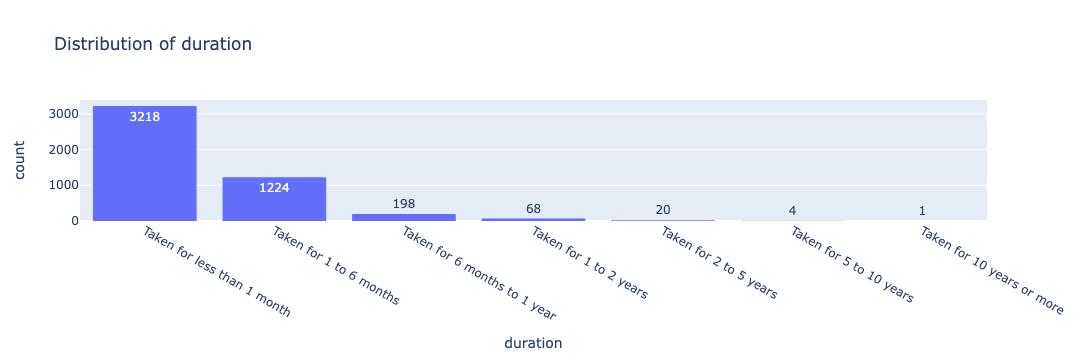

In [33]:
# Plots distribution of the "Reviewer_Nationality"
fig = px.histogram(lr_df, x = 'duration', title = 'Distribution of duration', text_auto=True)
fig.update_xaxes(categoryorder = 'total descending')
fig.show()

In [34]:
# Checking the value counts
lr_df['duration'].value_counts()/lr_df.shape[0]

Taken for less than 1 month     0.679907
Taken for 1 to 6 months         0.258610
Taken for 6 months to 1 year    0.041834
Taken for 1 to 2 years          0.014367
Taken for 2 to 5 years          0.004226
Taken for 5 to 10 years         0.000845
Taken for 10 years or more      0.000211
Name: duration, dtype: float64

We see that the majority of the reviewers have taken the drug for less than 1 month (70%). We can binarize the column where those with "Taken for less than 1 month" will be encoded as 1 and the rest are encoded as 0.

In [35]:
# Binarizing "duration"
lr_df['drugDuration'] = np.where(lr_df['duration'].str.contains('Taken for less than 1 month'), 1, 0)

In [36]:
# Sanity check
lr_df['drugDuration'].value_counts()

1    3218
0    1515
Name: drugDuration, dtype: int64

We can now drop the `duration` column.

In [37]:
# Drop the duration column
lr_df.drop(columns = 'duration', inplace = True)

### Drug and Drug Name

The `drug` and `drugName` columns tell the similar information. The `drug` column states the generic name of the drug and `drugName` states the brand name of the drug. Since it is similar, we can OHE the `drugName` column and drop the `drug` column.

We also want to later see how many of the words generated from the logistic regression coefficients are in the reviews for `Ozempic (semaglutide)` so we will drop the rows containing reviews for that column.

In [38]:
# Checking the unique values
lr_df['drugName'].unique()

array(['Wegovy (semaglutide)', 'Ozempic (semaglutide)',
       'Saxenda (liraglutide)', 'Contrave (bupropion / naltrexone)',
       'Alli (orlistat)', 'Xenical (orlistat)',
       'Qsymia (phentermine / topiramate)'], dtype=object)

We have now dropped the rows where `drugName` is `Ozempic (semaglutide)`. We can carry on with OHE the column.

In [39]:
# OHE drugName column
one_hot = pd.get_dummies(lr_df['drugName'])

# Join the encoded df
lr_df = lr_df.join(one_hot)

In [40]:
# Dropping drug and drugName columns
lr_df.drop(columns = ['drug', 'drugName'], inplace = True)

In [41]:
# Checking the dataset
lr_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4733 entries, 0 to 5232
Data columns (total 14 columns):
 #   Column                             Non-Null Count  Dtype 
---  ------                             --------------  ----- 
 0   date                               4733 non-null   object
 1   review                             4733 non-null   object
 2   rating                             4733 non-null   int64 
 3   upvotes                            4733 non-null   int64 
 4   page                               4733 non-null   int64 
 5   sentiment                          4733 non-null   int64 
 6   drugDuration                       4733 non-null   int64 
 7   Alli (orlistat)                    4733 non-null   uint8 
 8   Contrave (bupropion / naltrexone)  4733 non-null   uint8 
 9   Ozempic (semaglutide)              4733 non-null   uint8 
 10  Qsymia (phentermine / topiramate)  4733 non-null   uint8 
 11  Saxenda (liraglutide)              4733 non-null   uint8 
 12  Wegovy

In [42]:
# Identify the independent and dependent variables
X = lr_df['review']
y = lr_df['sentiment']

In [43]:
# modified preprocessor to exclude certain words
def my_preprocessor2(text):
    '''
    This function takes text as input. It first parses through sentences in order to help part-of-speech (POS) 
    tagging work best as good POS tags help out lemmatization. Each sentence gets broken into tokens (words),
    lemmatized, converted to lowercase, then stripped of non alphabetic or space characters (which there 
    shouldn't be). Then, any zero length strings or stopwords are removed and the result for the fully processed 
    sentence is appended to the final output.
    
    Parameters:
    -----------
    text: any kind of text
    
    Returns:
    --------
    output: a processed and clean list of words
    
    ''' 
    # Create dictionary for the part-of-speech tagging
    pos_map = {"J":wordnet.ADJ,
           "V":wordnet.VERB,
           "N":wordnet.NOUN,
           "R":wordnet.ADV}
    lemmatizer = WordNetLemmatizer()
    # List of english stopwords in lowercase
    stops = set(stopwords.words("english"))
    # remove drug name and common words
    stops.update(["wegovy", "ozempic", "saxenda", "contrave", "xenical", "alli", "qsymia", "nt", "lb", "lbs",\
                  "oz", "u", "etc", "mg", "take", "pound", "go", "nd", "th", "kg", "ago", "day", "week",\
                  "month", "get", "happen", "yet", "however", "l", "yo"])
    # First break into sentences to get pos tagging to work best
    as_sent = sent_tokenize(text,language='english')
    processed = []
    for sent in as_sent:
        # Break each sentence into words
        tokens = word_tokenize(sent)
        # Get pos tags for lemmatization
        pos_tags = nltk.pos_tag(tokens)
        mapped_tags = list((tag[0],pos_map.get(tag[1][0],wordnet.NOUN)) for tag in pos_tags)
        lemmas = list(lemmatizer.lemmatize(*tagged) for tagged in mapped_tags)
        # Convert to lower after lemmatization
        as_str = " ".join(list(lemma.lower() for lemma in lemmas))
        # Remove unwanted punctuation and numbers
        cleaned = "".join(char for char in as_str if char in "abcdefghijklmnopqrstuvwxyz ")
        # Double check no empty strings and add to processed
        cleaned = list(word for word in cleaned.split() if len(word) > 0 and word not in stops )
        processed.extend(cleaned)
    return processed

Now that we have the `my_preprocessor2` function, we can used function in the TF-IDF vector to fit the data. We also want to be looking for unigrams (1-word) in the dataset. The fitted vectorizer is used to transform the input data (X) into a numerical representation. The transform method converts each document into a vector representation using the learned vocabulary.

In [44]:
# Instantiate the Tfidf vectorizer
vectorized = TfidfVectorizer(preprocessor = my_preprocessor2, # use our custom preprocessor
                             tokenizer = lambda l:l,          # skip tokenization, our preprocessor returns words
                             min_df = 20,                     # require words be in at least 20 documents
                             max_features = 500)              # limiting the maximum number of features to 500        

# Fit the vectorizer
vectorized = vectorized.fit(X)

# Transform the vectorizer
reviews_transformed = vectorized.transform(X)

/Users/justinanguyen/anaconda3/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning:

The parameter 'token_pattern' will not be used since 'tokenizer' is not None'



## Fitting a Classifier <a class="anchor" id="classifier"></a>

Now that our `review` column has been vectorized, we can fit it to a logistic regression model. This will allow us to see the highest model coefficients indicating positive sentiment and the lowest model coefficients indicating negative sentiment.

In [45]:
# Fitting a model
logreg = LogisticRegression()
logreg.fit(reviews_transformed, y)

LogisticRegression()

We can create a dataframe of the logistic regression coefficients and their features. We can extract the top 20 rows and plot them. Higher coefficients indicate a stronger influence of the corresponding independent variable on the probability of the event of interest occurring. In this case, we are looking for words indicating positive sentiment.

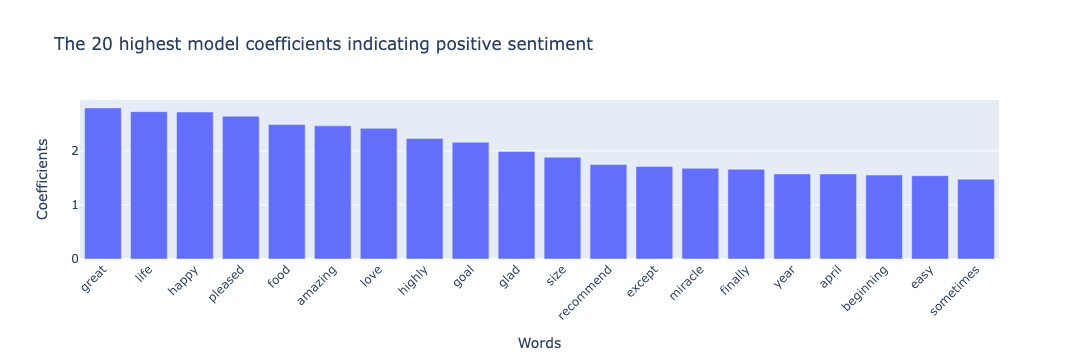

In [46]:
# Create a dataframe of the coeffients and the features
word_counts = pd.DataFrame(
    {"coefficients": logreg.coef_[0]},
    index = vectorized.get_feature_names_out()
).sort_values("coefficients", ascending=False)

# Select the top 20 rows
top_20_positive = word_counts.head(20)

# Create the bar plot
fig = px.bar(top_20_positive,
             x=top_20_positive.index,
             y='coefficients',
             labels={'coefficients': 'Coefficients', 'index': 'Words'},
             title="The 20 highest model coefficients indicating positive sentiment"
)

# Rotate x-axis labels by 45 degrees
fig.update_layout(xaxis_tickangle=-45)

# Show the plot
fig.show()

We can also get the bottom 20 rows which would indicate negative sentiment.

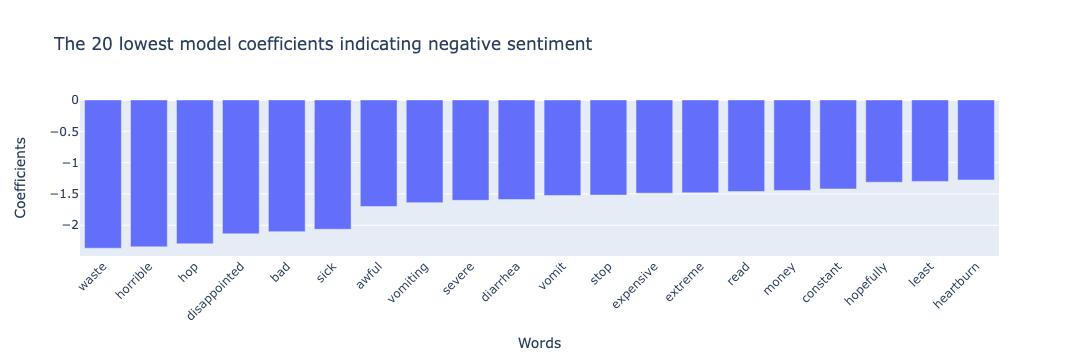

In [47]:
# Sort the DataFrame by 'coefficients' column in ascending order and select the top 20 rows
top_20_negative = word_counts.sort_values("coefficients", ascending=True).head(20)

# Create the bar plot
fig = px.bar(top_20_negative, x=top_20_negative.index, y="coefficients",
             title="The 20 lowest model coefficients indicating negative sentiment",
             labels={"coefficients": "Coefficients", "index": "Words"})

# Rotate x-axis labels by 45 degrees
fig.update_layout(xaxis_tickangle=-45)

# Show the plot
fig.show()


With the graphs above show the 20 highest model coefficients indicating positive sentiment and the 20 lowest model coefficients indicating negative sentiment, we can see if any of them properly indicate positive / negative sentiment. 

To see the comparison between these drugs to Ozempic, we can take those features and see how many of them appear in the Ozempic (semaglutide) reviews.

## Comparing LR Coefficients to Ozempic Reviews <a class="anchor" id="ozempic"></a> 

We first need to read in the CSV file containing the Ozempic (semaglutide) reviews.

To make the analysis easier, we will keep the rows where `drugName` is `Ozempic (semaglutide)` and drop all the other rows.

In [48]:
# Keep only rows where drugName is Ozempic (semaglutide)
drug_df = drug_df[drug_df['drugName'] == 'Ozempic (semaglutide)']

Then, we can clean and preprocess the data to get the vocabulary.

In [49]:
clean_drug_reviews = []
word_counts = {'Ozempic (semaglutide)': Counter()}

# Cleans and splits text
# And counts the words
for review in drug_df['review']:
    # Join the preprocessed words from a review into a single string with words separated by a space
    clean = " ".join(my_preprocessor2(review))  
    # Add the preprocessed review to the list of clean reviews
    clean_drug_reviews.append(clean) 
    # Split the preprocessed review into individual words
    words = clean.split()
    # Adds the individuals words to the list of words
    word_counts['Ozempic (semaglutide)'].update(words)

We can loop through the 20 words that indicate positive sentiment and count the frequency it appears in the Ozempic drug reviews. We can do the same for the 20 words that indicate negative sentiment.

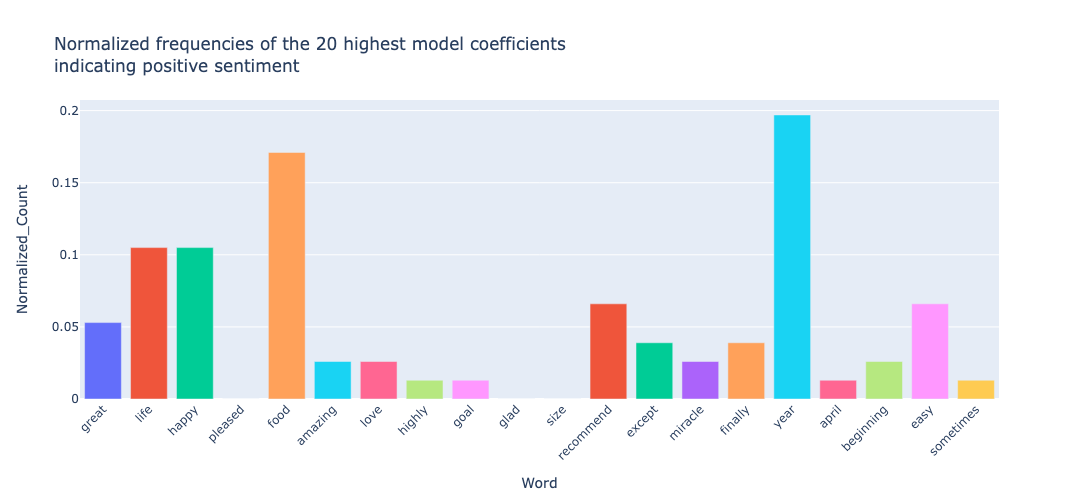

         Word  Count  Normalized_Count
0       great      4             0.053
1        life      8             0.105
2       happy      8             0.105
3     pleased      0             0.000
4        food     13             0.171
5     amazing      2             0.026
6        love      2             0.026
7      highly      1             0.013
8        goal      1             0.013
9        glad      0             0.000
10       size      0             0.000
11  recommend      5             0.066
12     except      3             0.039
13    miracle      2             0.026
14    finally      3             0.039
15       year     15             0.197
16      april      1             0.013
17  beginning      2             0.026
18       easy      5             0.066
19  sometimes      1             0.013


In [50]:
# List of words to search for
pos_search_words = top_20_positive.index.tolist()

# Create an empty list to store the word counts
pos_word_counts_list = []

# Iterate over each word in the search_words list
for word in pos_search_words:
    if word in word_counts['Ozempic (semaglutide)']:
        count = word_counts['Ozempic (semaglutide)'][word]
        pos_word_counts_list.append({'Word': word, 'Count': count})
    else:
        pos_word_counts_list.append({'Word': word, 'Count': 0})

# Create a DataFrame from the word_counts_list
pos_word_counts_df = pd.DataFrame(pos_word_counts_list)

# Normalize the counts
total_count = pos_word_counts_df['Count'].sum()
pos_word_counts_df['Normalized_Count'] = round(pos_word_counts_df['Count'] / total_count, 3)

# Plot the normalized word counts
fig = px.bar(pos_word_counts_df, x='Word', y='Normalized_Count',\
             title="Normalized frequencies of the 20 highest model coefficients<br>indicating positive sentiment",\
             color='Word')

# Update layout properties
fig.update_layout(xaxis_tickangle=-45,  
                  showlegend=False,   
                  width=800,            
                  height=500)

# Show the plot
fig.show()

# Print the dataframe
print(pos_word_counts_df)

We see that some words are present in the Ozempic drug review, with the word "lose" being the most frequently occurring word.

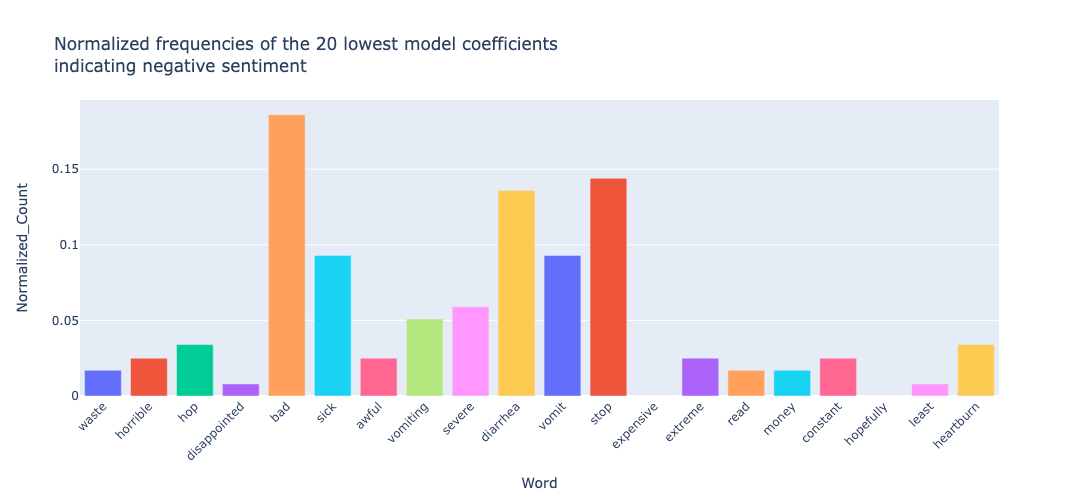

            Word  Count  Normalized_Count
0          waste      2             0.017
1       horrible      3             0.025
2            hop      4             0.034
3   disappointed      1             0.008
4            bad     22             0.186
5           sick     11             0.093
6          awful      3             0.025
7       vomiting      6             0.051
8         severe      7             0.059
9       diarrhea     16             0.136
10         vomit     11             0.093
11          stop     17             0.144
12     expensive      0             0.000
13       extreme      3             0.025
14          read      2             0.017
15         money      2             0.017
16      constant      3             0.025
17     hopefully      0             0.000
18         least      1             0.008
19     heartburn      4             0.034


In [51]:
# List of words to search for
neg_search_words = top_20_negative.index.tolist()

# Create an empty list to store the word counts
neg_word_counts_list = []

# Iterate over each word in the search_words list
for word in neg_search_words:
    if word in word_counts['Ozempic (semaglutide)']:
        count = word_counts['Ozempic (semaglutide)'][word]
        neg_word_counts_list.append({'Word': word, 'Count': count})
    else:
        neg_word_counts_list.append({'Word': word, 'Count': 0})

# Create a DataFrame from the word_counts_list
neg_word_counts_df = pd.DataFrame(neg_word_counts_list)

# Normalize the counts
total_count = neg_word_counts_df['Count'].sum()
neg_word_counts_df['Normalized_Count'] = round(neg_word_counts_df['Count'] / total_count, 3)

# Plot the normalized word counts
fig = px.bar(neg_word_counts_df, x='Word', y='Normalized_Count',\
             title="Normalized frequencies of the 20 lowest model coefficients<br>indicating negative sentiment",\
             color='Word')

# Update layout properties
fig.update_layout(xaxis_tickangle=-45,  
                  showlegend=False,   
                  width=800,            
                  height=500)

# Show the plot
fig.show()

# Print the dataframe
print(neg_word_counts_df)